# Bernstein-Vazirani Algorithm

In this section, we first introduce the Bernstein-Vazirani problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run on a simulator and device.

## Contents

1. [Introduction](#introduction)    
   1.1 [Bernstein-Vazirani Problem](#bvproblem)    
   1.2 [Bernstein-Vazirani Algorithm](#bvalgorithm)    
2. [Example](#example)
3. [Qiskit Implementation](#implementation)     
   3.1 [Simulation](#simulation)     
   3.2 [Device](#device)     
4. [Problems](#problems)
5. [References](#references)

## 1. Introduction <a id='introduction'></a>

The Bernstein-Vazirani algorithm, first introduced in Reference [1], can be seen as an extension of the Deutsch-Josza algorithm covered in the last section. It showed that there can be advantages in using a quantum computer as a computational tool for more complex problems compared to the Deutsch-Josza problem.

### 1a. Bernstein-Vazirani Problem <a id='bvproblem'> </a>

We are again given a hidden function Boolean $f$, which takes as as input a string of bits, and returns either $0$ or $1$, that is:
<center>$f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ where } x_n \textrm{ is }0 \textrm{ or } 1  $. 

Instead of the function being balanced or constant as in the Deutsch-Josza problem, now the function is guaranteed to return the bitwise product of the input with some string, $s$. In other words, given an input $x$, $f(x) = s \cdot x \, \text{(mod 2)}$. We are expected to find $s$.

### 1b. Bernstein-Vazirani Algorithm <a id='bvalgorithm'> </a>

#### Classical Solution
Classically, the oracle returns $f_s(x) = s \cdot x \mod 2$ given an input $x$. Thus, the hidden bit string $s$ can be revealed by querying the oracle with $x = 1, 2, \ldots, 2^i, \ldots, 2^{n-1}$, where each query reveals the $i$-th bit of $s$ (or, $s_i$). For example, with $x=1$ one can obtain the least significant bit of $s$, and so on. This means we would need to call the function $f_s(x)$ $n$ times. 


#### Quantum Solution

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$. The quantum Bernstein-Vazirani algorithm to find the hidden integer is very simple: (1) start from a $|0\rangle^{\otimes n}$ state, (2) apply Hadamard gates, (3) query the oracle, (4) apply Hadamard gates, and (5) measure, generically illustrated below:

![image1](images/bernsteinvazirani_steps.jpeg)

The correctness of the algorithm is best explained by looking at the transformation of a quantum register $|a \rangle$ by $n$ Hadamard gates, each applied to the qubit of the register. It can be shown that:

$$
|a\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle.
$$

In particular, when we start with a quantum register $|0\rangle$ and apply $n$ Hadamard gates to it, we have the familiar quantum superposition:

$$
|0\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle,
$$

which is slightly different from the Hadamard transform of the reqister $|a \rangle$ by the phase $(-1)^{a\cdot x}$. 

Now, the quantum oracle $f_a$ returns $1$ on input $x$ such that $a \cdot x \equiv 1 \mod 2$, and returns $0$ otherwise. This means we have the following transformation:

$$
|x \rangle \xrightarrow{f_a} | x \rangle = (-1)^{a\cdot x} |x \rangle. 
$$

The algorithm to reveal the hidden integer follows naturally by querying the quantum oracle $f_a$ with the quantum superposition obtained from the Hadamard transformation of $|0\rangle$. Namely,

$$
|0\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle \xrightarrow{f_a} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle.
$$

Because the inverse of the $n$ Hadamard gates is again the $n$ Hadamard gates, we can obtain $a$ by

$$
\frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle \xrightarrow{H^{\otimes n}} |a\rangle.
$$


## 2. Example  <a id='example'></a>

Let's go through a specific example for $n=2$ qubits and a secret string $s=11$. Note that we are following the formulation in Reference [2] that generates a circuit for the Bernstein-Vazirani quantum oracle using only one register. 

<ol>
    <li> The register of two qubits is initialized to zero:
    

$$\lvert \psi_0 \rangle = \lvert 0 0 \rangle$$

 
   </li>

   <li> Apply a Hadamard gate to both qubits:
    

$$\lvert \psi_1 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle + \lvert 0 1 \rangle + \lvert 1 0 \rangle + \lvert 1 1 \rangle \right) $$

 
   </li>

   <li> For the string $s=11$, the quantum oracle can be implemented as $\text{Q}_f = Z_{1}Z_{2}$:
    

$$\lvert \psi_2 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle - \lvert 0 1 \rangle - \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)$$

 
   </li>

   <li> Apply a Hadamard gate to both qubits:
    

$$\lvert \psi_3 \rangle = \lvert 1 1 \rangle$$

 
   </li>

   <li> Measure to find the secret string $s=11$
   </li>


</ol>



## 3. Qiskit Implementation  <a id='implementation'></a>

We now implement the Bernstein-Vazirani algorithm with Qiskit for a two bit function with $s=11$.

In [1]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

We first set the number of qubits used in the experiment, and the hidden integer $s$ to be found by the algorithm. The hidden integer $s$ determines the circuit for the quantum oracle. 

In [2]:
nQubits = 2 # number of physical qubits used to represent s
s = 3       # the hidden integer 

# make sure that a can be represented with nqubits
s = s % 2**(nQubits)

We then use Qiskit to program the Bernstein-Vazirani algorithm.

In [3]:
# qubits for querying the oracle and finding the hidden integer
# bits for recording the measurement
bvCircuit = QuantumCircuit(nQubits)
barriers = True

# Apply Hadamard gates before querying the oracle
for i in range(nQubits):
    bvCircuit.h(i)
    
# Apply barrier 
if barriers:
    bvCircuit.barrier()

# Apply the inner-product oracle
for i in range(nQubits):
    if (s & (1 << i)):
        bvCircuit.z(i)
    else:
        bvCircuit.iden(i)
        
# Apply barrier 
if barriers:
    bvCircuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(nQubits):
    bvCircuit.h(i)

# Measurement
bvCircuit.measure_all()

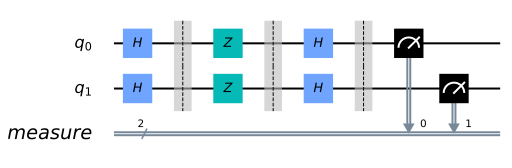

In [4]:
bvCircuit.draw(output='mpl')

### 3a. Experiment with Simulators  <a id='simulation'></a>

We can run the above circuit on the simulator. 

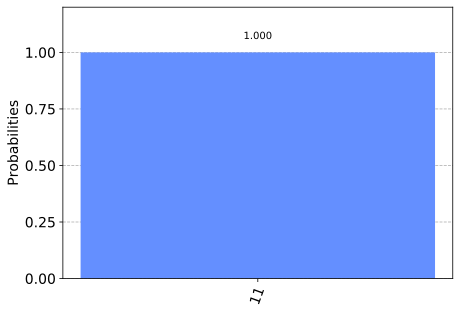

In [5]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(bvCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is the binary representation of the hidden integer $3$ $(11)$. 

### 3b. Experiment with Real Devices <a id='device'></a>

We can run the circuit on the real device as below.

In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_burlington


In [7]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(bvCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


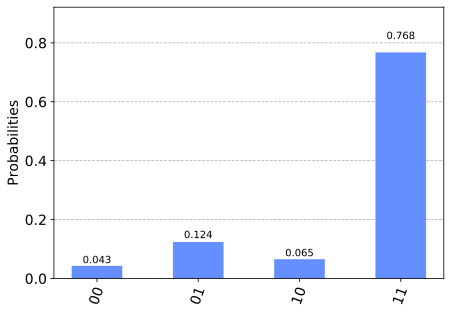

In [8]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, most of the results are $11$. The other results are due to errors in the quantum computation. 

## 4. Problems <a id='problems'></a>

1. The above [implementation](#implementation) of Bernstein-Vazirani is for a secret bit string of $s = 11$. Modify the implementation for a secret string os $s = 1011$. Are the results what you expect? Explain.
2. The above [implementation](#implementation) of Bernstein-Vazirani is for a secret bit string of $s = 11$. Modify the implementation for a secret string os $s = 1110110101$. Are the results what you expect? Explain.


## 5. References <a id='references'></a>
1. Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473, [doi:10.1137/S0097539796300921](https://doi.org/10.1137/S0097539796300921).
2. Jiangfeng Du, Mingjun Shi, Jihui Wu, Xianyi Zhou, Yangmei Fan, BangJiao Ye, Rongdian Han (2001) "Implementation of a quantum algorithm to solve the Bernstein-Vazirani parity problem without entanglement on an ensemble quantum computer", Phys. Rev. A 64, 042306, [10.1103/PhysRevA.64.042306](https://doi.org/10.1103/PhysRevA.64.042306), [arXiv:quant-ph/0012114](https://arxiv.org/abs/quant-ph/0012114). 

In [9]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.1',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.6.0',
 'qiskit-aqua': '0.6.5',
 'qiskit': '0.17.0'}